In [1]:
#import libraries
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

<b>Data Merging</b>

In [91]:
#load data
df_ableton = pd.read_csv('../data/ableton_data_20nov2022.csv', low_memory=False)
df_flstudio = pd.read_csv('../data/flstudio_data_20nov2022.csv', low_memory=False)

#Combined Data and assign 1 = ableton and 0 = flstudio to differentiate the source
df_ableton["label"] = 1
df_ableton = df_ableton[['label','title','selftext']]
df_flstudio["label"] = 0
df_flstudio = df_flstudio[['label','title','selftext']]
df_main = pd.concat([df_ableton, df_flstudio])

<b>Defining Functions for Cleaning</b>

In [92]:
#define function to clean text

df_cleaning_text = pd.read_csv('../data/cleaning_text.csv', low_memory=False)

def cleaning_text(text):
    
    try:   
        for i in range(df_cleaning_text.shape[0]):
            text = text.replace(str(df_cleaning_text.word[i]),str(df_cleaning_text.replacement[i]))
        
            text = re.sub(r'http\S+', '', text) #remove URL
    
        if text == '[removed]': #replace [removed] as blank
            text = ""
        
        return text

    except:
        return text

In [93]:
#define function to clean spelling
#the cleaning_word file is blank for the submission 
#refer to cleaning_word_archive for  the cumulative list

df_cleaning_word = pd.read_csv('../data/cleaning_word.csv', low_memory=False)

def cleaning_word(text):
    
    try:   
        for i in range(df_cleaning_word.shape[0]):
             
            text = text.replace(" " + str(df_cleaning_word.word[i]) + " ",
                                " " + str(df_cleaning_word.replacement[i]) + " ")
          
        return text
    
    except:
        return text

In [94]:
#define function to combine terms

df_cleaning_terms = pd.read_csv('../data/cleaning_terms.csv', low_memory=False)

def cleaning_terms(text):
    
    try:   
        for i in range(df_cleaning_terms.shape[0]):
              
            text = text.replace(" " + str(df_cleaning_terms.word[i]) + " ",
                                " " + str(df_cleaning_terms.replacement[i]) + " ")
                
        return text
    
    except:
        return text

In [95]:
#define function for lemmazization

def lemmatize_text(text):  
    
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    
    try:
        text = ' '.join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)])
    
        return text
    
    except:
        return text

In [96]:
#checking on stop words
stop = set(stopwords.words('english'))
print(stop)

{'will', 'our', "shan't", 'haven', 'here', 'needn', 'just', 'more', 'so', 'mightn', 'as', 'on', 'their', 'very', 'if', "isn't", 'then', 'an', 'with', 'won', "shouldn't", 'over', "you'd", 'have', 'mustn', 'm', 'for', 'shouldn', 'up', 'into', 'down', 'who', 'she', 'hasn', 'were', 'a', "that'll", 'aren', 'them', "don't", 'ain', 'in', 's', 'herself', 'once', 'there', 't', 'above', 'nor', "aren't", 'against', "didn't", "doesn't", 'shan', 'when', 'weren', 'during', 'don', 'the', 'her', 'under', 'why', "needn't", 'those', 'off', 'am', 'but', 'he', 'o', 'your', 'each', 'now', 'has', 'other', "wouldn't", 'out', 'do', "she's", 'they', 'hadn', "mightn't", 'himself', 'or', 'be', 'ma', 'and', 'below', 'again', 'at', 'should', 'ourselves', 'ours', 'this', 'being', 'which', 'yours', 'between', "mustn't", "won't", 'theirs', 'having', 'from', 'are', 'through', 'my', 'its', "you'll", 'itself', 'i', 'what', 've', 'is', 'had', 'didn', "it's", 'about', 'after', 'any', 'both', 'all', 'can', "should've", 'co

In [97]:
#include new stop words
new_stops = {"i'm", "we've", "hi", "doe", "doesn't", "0", "was", "wa"}
stop.update(new_stops)

In [98]:
#define function to remove stop words

def remove_stop(text):
    tokenizer = RegexpTokenizer(r'\w+')

    if len(str(text)) != 0:
        word_tokens = tokenizer.tokenize(str(text))
        
        for i in word_tokens:
            no_stop = ' '.join([w for w in word_tokens if not w.lower() in stop])
            
        try:   
            return no_stop
        
        except:
            return text
    else:
        return None

In [99]:
#initate new column 'cleantext' and cleantitle
df_main['cleantext'] = df_main['selftext'].copy()
df_main['cleantitle'] = df_main['title'].copy()

In [101]:
df_main.to_csv(r'../data/clean_data.csv', index=False)

<b>Apply Cleaning</b><br>
This is an iterative process as progressing cleaning is done based on the output from modelling.

In [50]:
#recall cleaning data
df_main = pd.read_csv('../data/clean_data.csv', low_memory=False)

In [80]:
df_main.groupby(['label']).describe()

wordcount                                                      
          count       mean        std   min   25%   50%   75%     max
label                                                                
0        9305.0  46.327673  39.176953  20.0  26.0  36.0  53.0   981.0
1       14881.0  54.636718  52.849603  20.0  29.0  41.0  63.0  2001.0

In [52]:
#initate cleaning text
df_main['cleantext'] = df_main['cleantext'].apply(cleaning_text)
df_main['cleantitle'] = df_main['cleantitle'].apply(cleaning_text)

In [53]:
#convert to string
df_main["cleantext"] = df_main["cleantext"].astype('string')
df_main["cleantitle"] = df_main["cleantitle"].astype('string')

In [79]:
#remove duplicates
df_main = df_main.drop_duplicates(subset='selftext', keep="first")
df_main = df_main.drop_duplicates(subset='title', keep="first")

In [55]:
#set text to lowercase
df_main['cleantext'] = df_main['cleantext'].str.lower()
df_main['cleantitle'] = df_main['cleantitle'].str.lower()

In [75]:
#drop text with less than 20 words
df_main['wordcount'] = [len(re.findall(r'\w+', str(i))) for i in df_main['cleantext']]
df_main = df_main.drop(df_main[df_main.wordcount < 20].index)

In [57]:
#customised processing of cleaning words e.g. spelling
df_main['cleantext'] = df_main['cleantext'].apply(cleaning_word)
df_main['cleantitle'] = df_main['cleantitle'].apply(cleaning_word)

In [58]:
#customised processing of combining terms
df_main['cleantext'] = df_main['cleantext'].apply(cleaning_terms)
df_main['cleantitle'] = df_main['cleantitle'].apply(cleaning_terms)

In [59]:
#lemmatization
df_main['cleantext'] = df_main['cleantext'].apply(lemmatize_text)
df_main['cleantitle'] = df_main['cleantitle'].apply(lemmatize_text)

In [73]:
#remove stop words
df_main["cleantext"] = df_main.cleantext.apply(remove_stop)
df_main["cleantitle"] = df_main.cleantitle.apply(remove_stop)

In [92]:
#summary of clean data
df_main.groupby(['label']).describe()

wordcount                                                      
          count       mean        std   min   25%   50%   75%     max
label                                                                
0        9305.0  46.327673  39.176953  20.0  26.0  36.0  53.0   981.0
1       14881.0  54.636718  52.849603  20.0  29.0  41.0  63.0  2001.0

In [82]:
#to ensure all data are string before merging
df_main["cleantext"] = df_main["cleantext"].astype('string')
df_main["cleantitle"] = df_main["cleantitle"].astype('string')

In [83]:
df_main["combinedtext"] = df_main["cleantext"].map(str) + " " + df_main["cleantitle"].map(str)

In [91]:
#export data
df_main.to_csv(r'../data/model_data.csv', index=False)

<b>Word Counts</b>

In [2]:
#reload clean data
df_main = pd.read_csv('../data/model_data.csv', low_memory=False)

In [3]:
#check that the wordcount is at least 20
df_main.wordcount.describe()

count    24186.000000
mean        51.440007
std         48.220941
min         20.000000
25%         28.000000
50%         39.000000
75%         59.000000
max       2001.000000
Name: wordcount, dtype: float64

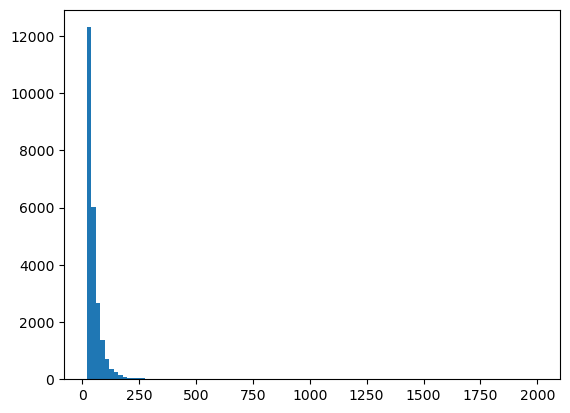

In [4]:
#distribution of wordcount
plt.hist(df_main.wordcount, bins=100)
plt.show()

In [5]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english')
cv_bigrams.fit(df_main.combinedtext)

bigrams_cv = cv_bigrams.transform(df_main.combinedtext)
bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names_out())

bigrams_df.sum().sort_values(ascending=False).head(15)

#fl_studio was expected to be a bigrams. Most of the top bigrams are related to technical terms for music production
#some are related to seeking for help

piano roll          1216
audio interface     1178
thanks advance      1082
midi controller     1060
midi keyboard        941
drum rack            852
fl studio            821
audio track          819
hey guy              812
feel like            771
sound like           762
midi track           759
need help            723
audio clip           694
music production     684
dtype: int64

In [6]:
bi_df = bigrams_df.sum().sort_values(ascending=False).head(15)

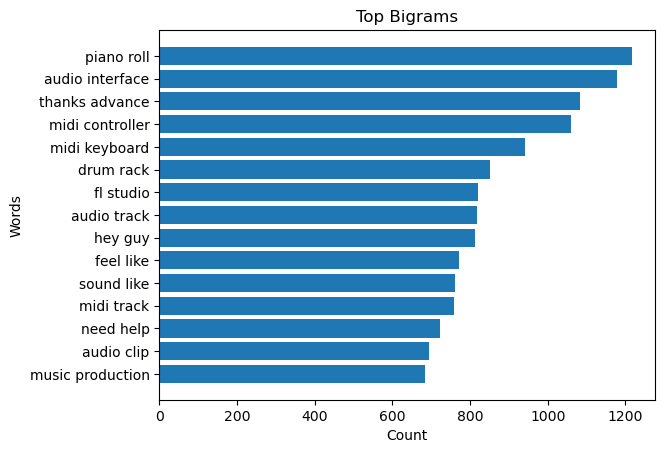

In [23]:
y_axis = list(bi_df.index)
x_axis = list(bi_df)
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Top Bigrams')
plt.ylabel('Bigrams')
plt.xlabel('Count')
plt.show()

In [3]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')
cv_trigrams.fit(df_main.combinedtext)

trigrams_cv = cv_trigrams.transform(df_main.combinedtext)
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names_out())

trigrams_df.sum().sort_values(ascending=False).head(15)

#Similarly to bigrams, the technical terms are more prominent and phrase relating to help

help greatly appreciated    237
external hard drive         151
akai mpk mini               143
note piano roll             134
max live device             116
fl engine x64               108
engine x64 dll              108
3rd party plugin            106
thanks advance help          91
2021 01 19t17                84
01 19t17 33                  84
help appreciated thanks      82
clip session view            81
new music production         74
macbook pro m1               72
dtype: int64

In [4]:
tri_df = trigrams_df.sum().sort_values(ascending=False).head(15)

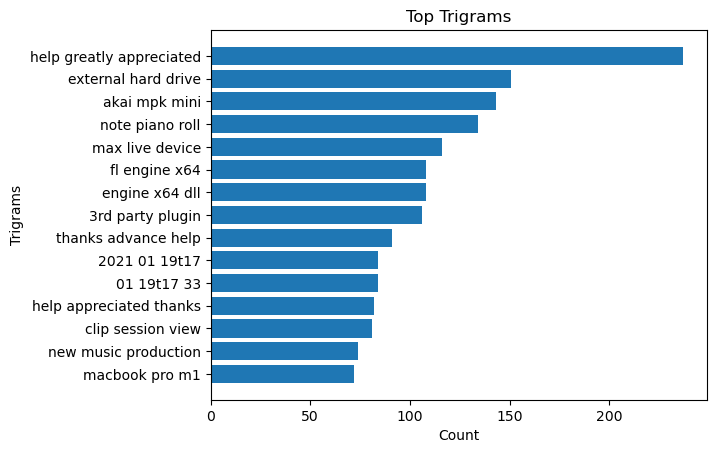

In [5]:
y_axis = list(tri_df.index)
x_axis = list(tri_df)
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Top Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Count')
plt.show()

<b>Top Words</b>

In [103]:
text_list = df_main.combinedtext.values.tolist()
word_list = []
for item in text_list:
    breakdown_words = word_tokenize(item)
    for word in breakdown_words:
        word_list.append(word)

In [104]:
#generate list of unique words
wordset = set(word_list)
unique_list = list(wordset)
len(unique_list)

29245

In [87]:
#generate count for each unique word
unique_count = []
process_count = 0
print("Processing in Progress......")
for x in unique_list:
    count = 0
    process_count += 1
    for y in word_list:
        if x == y:
            count += 1
    unique_count.append(count)
    if(process_count % 5000 == 0):
        print(str(process_count) + " words completed")
print("Process Completed......")

Processing in Progress......
5000 words completed
10000 words completed
15000 words completed
20000 words completed
25000 words completed
Process Completed......


In [88]:
df_word = pd.DataFrame(list(zip(unique_list, unique_count)), columns =['word', 'count'])

In [89]:
#export word list for manual data cleaning referencce
df_word.to_csv(r'../data/word_list.csv', index=False)

In [77]:
#reload clean data
df_word = pd.read_csv('../data/word_list.csv', low_memory=False)

In [78]:
#top words
df_word = df_word.sort_values(by=['count'], ascending=False)

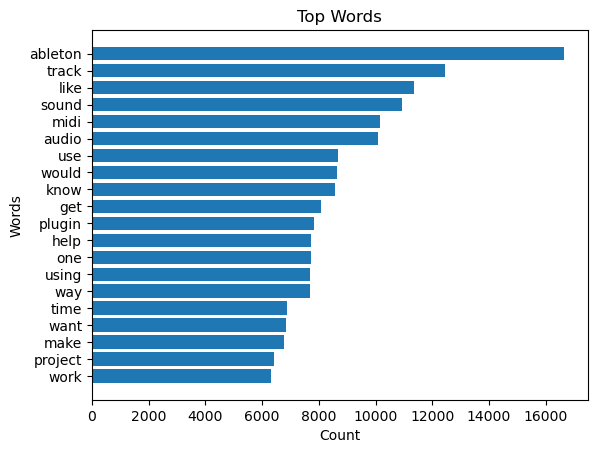

In [79]:
y_axis = list(df_word.iloc[0:20,0])
x_axis = list(df_word.iloc[0:20,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Top Words')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()